In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
# 1 - index the datasources which are 3 blog post link here 
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


USER_AGENT environment variable not set, consider setting it to identify your requests.


[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nLearn the basics\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            \n              Learn the basics\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n    \n  \n  Home\n\n        \n\n\n\n          \n  \n    \n  \n  API reference\n\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n    \n  \n    Home\n  \n\n    \n  \n\n\n\n\n\n\n\n\n            \n  \n    Home\n  \n\n

In [3]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)


retriever=vectorstore.as_retriever()

In [4]:
retriever.invoke("what is mapreduce in langgraph")

[Document(id='dae068a5-50e4-49c6-a8c0-5478a3995422', metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'How to create map-reduce branches for parallel execution', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content='Companies using LangGraph\n  \n\n    \n  \n\n\n\n\n\n    \n  \n    FAQ\n  \n\n    \n  \n\n\n\n\n\n    \n  \n    Troubleshooting\n  \n\n    \n  \n\n\n\n\n\n\n    \n  \n    LangGraph Academy Course\n  \n\n    \n  \n\n\n\n\n\n\n\n\n\n\n\n    \n  \n    API reference\n  \n\n    \n  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n      Table of contents\n    \n\n\n\n\n      \n        Setup\n      \n    \n\n\n\n\n\n      \n        Define the graph\n      \n    \n\n\n\n\n\n      \n        Use the graph\n      \n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n    Home\n  \n\n\n\n\n\n    Guides\n  \n\n\n\n\n\n    How-to Guides\n  \n\n\n\n\n\n    LangGraph\n  \n\n\n\n\n\n    Controllability\n  \n\n\n\n\n\n\n\n\n\n\nHow to create map-reduce branch

In [6]:
#2 - create a retriever tool
from langchain.tools.retriever import create_retriever_tool

#create retriever tool function takes in 3 arguments (retriver object, name of tool, description of tool)
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [7]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001CAA6D4A840>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001CAA796BE90>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000001CAA6E41440>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001CAA796BE90>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), 

In [8]:
tools=[retriever_tool]

In [10]:
# 3 - Define Agent State 
# Define a graph. A state object (list of messages) is passed around to each node. Each node in our graph will append to it.
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

# AgentState class inherits from TypedDict, which is used to define structured dictionaries where each key has a specific type
class AgentState(TypedDict):
    
    # The add_messages defines how an update should be processed
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [11]:
# 4 - LLM setup
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
llm.invoke("Hey there")

AIMessage(content='Hello! How can I assist you today? Feel free to ask any questions or let me know if you need help with anything.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 31, 'total_tokens': 58, 'completion_time': 0.135, 'prompt_time': 0.003906449, 'queue_time': 0.24724826399999997, 'total_time': 0.138906449}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-bb5006b2-23ec-4c22-94d5-77a88c4c5078-0', usage_metadata={'input_tokens': 31, 'output_tokens': 27, 'total_tokens': 58})

# How the Function Works in the below Workflow
- The agent receives a conversation state.
- It loads a chat model (ChatGroq).
- It binds available tools (like retrieval tools).
- The model generates a response based on the messages.
- The function returns the updated messages with the new response.

In [ ]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="qwen-2.5-32b")
    model = model.bind_tools(tools) #attaching tool to the model 
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Nodes and Edges
We can lay out an agentic RAG graph like this:
- The state is a set of messages
- Each node will update (append to) state
- Conditional edges decide which node to visit next

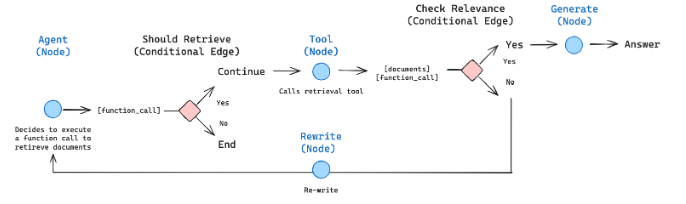

In [13]:
# 5 - Nodes and Edges
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# grade_documents Function summary:

The function grade_documents(state) is responsible for checking whether retrieved documents are relevant to the user's question. Based on this check, it decides whether to:

- Proceed with generating a response ("generate") if the document is relevant.
- Rewrite the question ("rewrite") if the document is not relevant

In [14]:
### Edges
# -> This is a type hint specifying that the function must return either "generate" or "rewrite".
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model - grade class is inheriting from BaseModel class from Pydantic Python library
    # The grade class is only needed within this function, so defining it locally keeps it encapsulated.
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
  

    # LLM
    model = ChatGroq(model="qwen-2.5-32b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)
    # The .with_structured_output method in LangChain simplifies getting structured output from LLMs

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool
    
    #Extracts messages from state where messages[0] → The original user question | messages[-1] → The retrieved document (last message).
    messages = state["messages"]

    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [16]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="qwen-2.5-32b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [17]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # 

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [19]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="qwen-2.5-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

# Graph - Summary of the Workflow
- Start at "agent" → Decide whether to retrieve documents.
- If retrieval is needed → Go to "retrieve".
- Check document relevance (grade_documents):
- If relevant → Go to "generate" and finish.
- If not relevant → Go to "rewrite", modify the query, and retry.
- The process ends at "generate" or directly from "agent" if retrieval isn't needed.

In [20]:
# 6 - Create Graph
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question or query
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

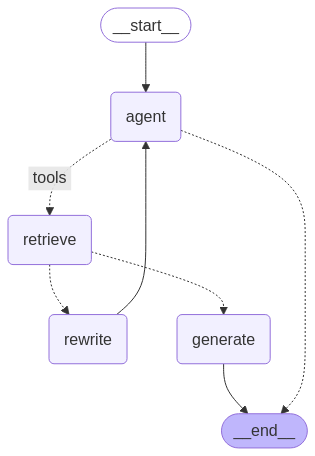

In [21]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
graph.invoke({"messages":"What is machine learning"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='5c80b763-1218-4442-8fbe-93cff33eda89'),
  AIMessage(content='Machine learning is a method of teaching computers to recognize patterns and make decisions using data, without being explicitly programmed. It involves algorithms that can learn from and make predictions on data. Machine learning is a subset of artificial intelligence (AI) and is widely used in various applications such as image and speech recognition, recommendation systems, and predictive analytics.\n\nWould you like to know more about specific aspects of machine learning, such as types of machine learning, common algorithms, or applications?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 183, 'total_tokens': 277, 'completion_time': 0.47, 'prompt_time': 0.010879585, 'queue_time': 0.253767533, 'total_time': 0.480879585}, 'model_name': 'qwen-2.5-32b', 'system_fin

In [23]:
inputs={
    "messages": [
        ("user", "What is MAchine LEarning"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='It seems like there might have been a small typo in your question. I believe you might be asking about "Machine Learning." Machine Learning is a method of teaching computers to recognize patterns, make decisions, and predict outcomes without being explicitly programmed to do so. It involves algorithms that can learn from and make predictions on data. Would you like more detailed information on specific aspects of Machine Learning, such as types of learning, applications, or examples?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 185, 'total_tokens': 274, 'completion_time': 0.445, 'prompt_time': 0.010879523, 'queue_time': 0.2399673, 'total_time': 0.455879523}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-5ff2b04b-42db-46b5-b0a5-499a2aaec34d-0', usage_metadata={'input_tokens': 185, 'output_tokens': 8